#Preliminaries

In [1]:
!pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.4 MB/s eta 0:00:00


In [2]:
pip install keras-balanced-batch-generator

In [3]:
import os
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Flatten, Bidirectional, LeakyReLU  #,CuDNNLSTM, CuDNNGRU
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow_addons as tfa
from keras_balanced_batch_generator import make_generator
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import array
import pandas as pd
import string
import random
import math

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:
np.set_printoptions(threshold=np.inf,linewidth=np.inf)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
homedir = '/content/drive/My Drive'

#Assign input folders

For model phase 1 - Limit the data to days that had hail in at least one location cell in Indiana. Other cells can be introduced later.

In [ ]:
hailDir = homedir + '/ERA5/model_input/hail/'

In [ ]:
noHailDir = homedir +  '/ERA5/model_input/nohail/'

Split the files into test/train split folders

In [ ]:
hailTrainTfds = homedir + '/ERA5/tfds/train/hail/'

In [ ]:
hailValTfds = homedir + '/ERA5/tfds/val/hail/'

In [ ]:
hailTestTfds = homedir + '/ERA5/tfds/test/hail/'

In [ ]:
noHailTrainTfds = homedir + '/ERA5/tfds/train/nohail/'

In [ ]:
noHailValTfds = homedir + '/ERA5/tfds/val/nohail/'

In [ ]:
noHailTestTfds = homedir + '/ERA5/tfds/test/nohail/'

In [ ]:
hTrainCount = os.listdir(hailTrainTfds)
hValCount = os.listdir(hailValTfds)
hTestCount = os.listdir(hailTestTfds)
nhTrainCount = os.listdir(noHailTrainTfds)
nhValCount = os.listdir(noHailValTfds)
nhTestCount = os.listdir(noHailTestTfds)
print("hTrainCount:",len(hTrainCount))
print("hValCount:",len(hValCount))
print("hTestCount:",len(hTestCount))
print("nhTrainCount:",len(nhTrainCount))
print("nhValCount:",len(nhValCount))
print("nhTestCount:",len(nhTestCount))

hTrainCount: 500
hValCount: 163
hTestCount: 166
nhTrainCount: 24797
nhValCount: 6200
nhTestCount: 7761


#Create the Tensor Flow pipeline

In [ ]:
#Use a large number of records in the pipeline batch so that the balancing generator will have enough records to choose from later.
batch_size = 5000
print(batch_size)
#AUTOTUNE = tf.data.AUTOTUNE

5000


In [ ]:
pipelineTF = tf.data.Dataset.list_files(homedir + '/ERA5/tfds/train/*/*',shuffle=True)
pipelineTF2 = tf.data.Dataset.list_files(homedir + '/ERA5/tfds/val/*/*',shuffle=True)
pipelineTF3 = tf.data.Dataset.list_files(homedir + '/ERA5/tfds/test/*/*',shuffle=True)

In [ ]:
#check the pipeline file list
for file in pipelineTF.take(2):
  print(file)

tf.Tensor(b'/content/drive/My Drive/ERA5/tfds/train/nohail/20191130337.npy', shape=(), dtype=string)
tf.Tensor(b'/content/drive/My Drive/ERA5/tfds/train/nohail/20140618179.npy', shape=(), dtype=string)


In [ ]:
#check the pipeline file list
for file in pipelineTF2.take(2):
  print(file)

tf.Tensor(b'/content/drive/My Drive/ERA5/tfds/val/nohail/20140221206.npy', shape=(), dtype=string)
tf.Tensor(b'/content/drive/My Drive/ERA5/tfds/val/nohail/20150717162.npy', shape=(), dtype=string)


In [ ]:
#check the pipeline file list
for file in pipelineTF3.take(2):
  print(file)

tf.Tensor(b'/content/drive/My Drive/ERA5/tfds/test/nohail/20130611275.npy', shape=(), dtype=string)
tf.Tensor(b'/content/drive/My Drive/ERA5/tfds/test/nohail/20201023360.npy', shape=(), dtype=string)


In [ ]:
#create a function to map target from filepath.
def get_label(path):
  if tf.strings.split(path,os.sep)[-2] == 'hail':
    label = 1
  else:
    label = 0
  return label

In [ ]:
#create a function to get the features and tartgets from a given file in the pipeline
#Using examples from: https://stackoverflow.com/questions/71970277/loading-a-numpy-array-into-tensorflow-input-pipeline
def get_data(path):
  label = get_label(path)
  label = np.uint8(label)
  features = np.load(path)
  featuresTF = tf.convert_to_tensor(features, dtype=tf.float32)
  return label, featuresTF

train_ds =  pipelineTF.map(lambda item: tf.numpy_function(get_data, [item], (tf.uint8,tf.float32))) #.prefetch(AUTOTUNE) .cache()
val_ds =  pipelineTF3.map(lambda item: tf.numpy_function(get_data, [item], (tf.uint8,tf.float32))) #.prefetch(AUTOTUNE) .cache()
test_ds =  pipelineTF3.map(lambda item: tf.numpy_function(get_data, [item], (tf.uint8,tf.float32))) #.prefetch(AUTOTUNE) .cache()

In [ ]:
#point the x and y training arrays to the pipeline
y_train, X_train = next(iter(train_ds.batch(batch_size)))
print("Training data loader batch size:",batch_size)   #len(hTrainCount)+len(nhTrainCount)

Training data loader batch size: 5000


In [ ]:
#point the x and y training arrays to the pipeline
y_val, X_val = next(iter(val_ds.batch(len(hValCount)+len(nhValCount))))
print("validation data loader batch size:",len(hValCount)+len(nhValCount))

validation data loader batch size: 6363


In [ ]:
#check the pipeline arrays
y_train2 = y_train.numpy()
y_train3 = tf.keras.utils.to_categorical(y_train2)
print(type(y_train3))
X_train2 = X_train.numpy()
print(type(X_train2))
print(X_train2.shape)
print(y_train3.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(5000, 24, 92)
(5000, 2)


In [ ]:
#check the pipeline arrays
y_val2 = y_val.numpy()
y_val3 = tf.keras.utils.to_categorical(y_val2)
print(type(y_val3))
X_val2 = X_val.numpy()
print(type(X_val2))
print(X_val2.shape)
print(y_val3.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(6363, 24, 92)
(6363, 2)


In [ ]:
print(y_train3[:5])

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [ ]:
print(y_val3[:5])

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [ ]:
#check the data in the pipeline
for label, featuresTF in train_ds.take(1):
  print(label)
  print(featuresTF)

tf.Tensor(0, shape=(), dtype=uint8)
tf.Tensor(
[[-0.57  0.09  0.98 -1.4  -0.53  0.07  0.98 -1.32 -0.48  0.    0.97 -1.11 -0.38  0.    0.96 -1.54 -0.32  0.09  0.94 -0.56 -0.26  0.08  0.85  0.47 -0.2   0.11  0.81 -0.18 -0.15  0.1   0.78 -0.7  -0.1   0.09  0.75 -1.42 -0.06  0.08  0.73 -1.87 -0.02  0.09  0.72 -1.91  0.01  0.08  0.66 -2.    0.05  0.08  0.57 -2.23  0.07  0.07  0.54 -2.4   0.08  0.04  0.51 -2.54  0.1   0.02  0.48 -2.72  0.12  0.02  0.48 -2.95  0.14  0.03  0.48 -3.13  0.15  0.03  0.51 -3.06  0.16  0.03  0.45 -2.59  0.18  0.04  0.38 -1.64  0.2   0.05  0.3  -0.47  0.22  0.05  0.09  0.15]
 [-0.57  0.09  0.99 -0.38 -0.52  0.1   0.99 -0.06 -0.48  0.05  0.98  0.3  -0.39  0.03  0.97  0.17 -0.32  0.15  0.94 -0.27 -0.27  0.17  0.88  0.84 -0.21  0.25  0.83  2.15 -0.15  0.21  0.79  2.31 -0.1   0.14  0.73  2.08 -0.06  0.1   0.72  1.06 -0.02  0.09  0.72  0.02  0.01  0.05  0.66 -0.37  0.05  0.06  0.59 -0.69  0.07  0.07  0.54 -0.96  0.08  0.06  0.51 -1.23  0.1   0.04  0.48 -1.43  0.12  0.03 

In [ ]:
#check the data in the pipeline
for label, featuresTF in val_ds.take(1):
  print(label)
  print(featuresTF)

tf.Tensor(0, shape=(), dtype=uint8)
tf.Tensor(
[[-0.62  0.    0.9  -0.02 -0.56  0.    0.83 -0.3  -0.5  -0.01  0.8  -0.68 -0.39  0.    0.7  -1.64 -0.31 -0.01  0.57 -2.   -0.24 -0.01  0.48 -1.91 -0.19 -0.02  0.41 -1.81 -0.14  0.    0.38 -1.28 -0.1   0.02  0.38 -0.82 -0.06  0.08  0.3   0.64 -0.01  0.15  0.22  1.64  0.02  0.09  0.22  1.01  0.05  0.07  0.13  0.41  0.07  0.06  0.05  0.45  0.08  0.07  0.05  0.64  0.1   0.11  0.09  0.82  0.09  0.07  0.09  0.87  0.08  0.04  0.22  0.97  0.07  0.09  0.38  1.37  0.07  0.13  0.48  1.43  0.08  0.11  0.41  0.95  0.1   0.12  0.17  0.26  0.11  0.11  0.17  0.28]
 [-0.62  0.    0.89 -0.99 -0.56  0.    0.82 -1.37 -0.5   0.    0.8  -1.29 -0.4   0.    0.7  -1.26 -0.32 -0.01  0.51 -1.39 -0.24  0.    0.48 -1.76 -0.18  0.    0.41 -1.61 -0.14 -0.01  0.38 -0.91 -0.1   0.    0.34 -0.75 -0.06  0.03  0.3   0.21 -0.02  0.1   0.22  0.63  0.01  0.06  0.17 -0.22  0.05  0.06  0.13 -0.72  0.06  0.05  0.02 -0.3   0.08  0.08  0.02  0.3   0.1   0.13  0.09  0.66  0.1   0.09 

Make a balanced generator to pull in an even number of classes for each batch.

In [ ]:
#make the batch size small enough that there will be enough examples in the pipeline to choose from
genBatch = 5000
valBatch = 100

In [ ]:
generator = make_generator(X_train2, y_train3, genBatch, categorical=False)

In [ ]:
generator2 = make_generator(X_val2, y_val3, valBatch, categorical=False)

#Create an LSTM model to detect hail conditions from the features loaded above

1) Step throguh each 24 hour dail sequence to get a fuzzy match on the actual time of hail events for a given day.

2) For each day use a 23 x 4 feature matrix which is the wind speed, temperature, vertical velocity of wind, and dew point at each of 23 altitudes.

3) Output 1 binary classifier.

In [ ]:
steps = 24                #24 hour steps to convert from hourly features to a daily model that is agnostic to the actual time of hail
featnum = 92              #4 features at 23 altitudes (temperature, temperature - dew point, wind speed, and verticle velocity of the wind)
outsize = 1               #hail/no hail
epochs = 30
steps_per_epoch = round((len(hTrainCount) + len(nhTrainCount))/genBatch,0)
val_steps_per_epoch = round((len(hValCount) + len(nhValCount))/valBatch,0)
optimizer = tf.keras.optimizers.AdamW(learning_rate=.0001,beta_1=0.001,beta_2=0.9) #weight_decay=.0001
metric1 = tf.keras.metrics.TruePositives(thresholds=None, name=None, dtype=None)
metric4 = tf.keras.metrics.FalseNegatives()
metric2 = tf.keras.metrics.FalsePositives(thresholds=None, name=None, dtype=None)
metric3 = tf.keras.metrics.TrueNegatives()


In [ ]:
model = Sequential()
model.add(LSTM(276, activation='relu', input_shape=(steps,featnum),recurrent_regularizer='l1',return_sequences=True))
model.add(Dropout(.25))

model.add(LSTM(276, activation='relu', input_shape=(steps,featnum),recurrent_regularizer='l1',return_sequences=True))
model.add(Dropout(.25))

model.add(LSTM(276, activation='relu', input_shape=(steps,featnum),recurrent_regularizer='l1',return_sequences=False))
model.add(Dropout(.25))

model.add(Dense(276, activation='relu'))

model.add(Dense(outsize, activation='sigmoid'))
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[metric1,metric2,metric4,metric3])

In [ ]:
model.build(input_shape=(None, steps,featnum))

In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 24, 276)           407376    
                                                                 
 dropout_30 (Dropout)        (None, 24, 276)           0         
                                                                 
 lstm_32 (LSTM)              (None, 24, 276)           610512    
                                                                 
 dropout_31 (Dropout)        (None, 24, 276)           0         
                                                                 
 lstm_33 (LSTM)              (None, 276)               610512    
                                                                 
 dropout_32 (Dropout)        (None, 276)               0         
                                                                 
 dense_18 (Dense)            (None, 276)             

In [ ]:
# Define Keras callbacks for model checkpoint
modelPath = homedir + '/ERA5/model/hail_model.h5'
checkpoint = ModelCheckpoint(modelPath, monitor='val_loss', save_best_only=True, verbose=1)
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [ ]:
# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("GPU is available.")
    with tf.device("GPU:0"):  # Use the first GPU (if multiple are available)
        # Train the model (GPU)
        history = model.fit(generator, epochs=epochs,batch_size=genBatch, steps_per_epoch=steps_per_epoch,validation_data=generator2,validation_steps=val_steps_per_epoch,validation_batch_size=valBatch, shuffle=True, verbose=1,callbacks=checkpoint)

else:
    print("GPU is not available. Training on CPU.")
    # Train the model on CPU (if GPU is not available)
    history = model.fit(generator, epochs=epochs,batch_size=genBatch, steps_per_epoch=steps_per_epoch,validation_data=generator2,validation_steps=val_steps_per_epoch,validation_batch_size=valBatch, shuffle=True, verbose=1,callbacks=checkpoint) #,callbacks=checkpoint

GPU is not available. Training on CPU.
Epoch 1/30
5/5 [==============================] - ETA: 0s - loss: 218.3750 - true_positives_15: 12493.0000 - false_positives_15: 12468.0000 - false_negatives_15: 14.0000 - true_negatives_12: 25.0000
Epoch 1: val_loss improved from inf to 215.65332, saving model to /content/drive/My Drive/ERA5/model/hail_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5/5 [==============================] - 47s 8s/step - loss: 218.3750 - true_positives_15: 12493.0000 - false_positives_15: 12468.0000 - false_negatives_15: 14.0000 - true_negatives_12: 25.0000 - val_loss: 215.6533 - val_true_positives_15: 3165.0000 - val_false_positives_15: 2790.0000 - val_false_negatives_15: 73.0000 - val_true_negatives_12: 372.0000
Epoch 2/30
5/5 [==============================] - ETA: 0s - loss: 213.8570 - true_positives_15: 11752.0000 - false_positives_15: 10152.0000 - false_negatives_15: 701.0000 - true_negatives_12: 2395.0000
Epoch 2: val_loss improved from 215.65332 to 211.17178, saving model to /content/drive/My Drive/ERA5/model/hail_model.h5
5/5 [==============================] - 43s 9s/step - loss: 213.8570 - true_positives_15: 11752.0000 - false_positives_15: 10152.0000 - false_negatives_15: 701.0000 - true_negatives_12: 2395.0000 - val_loss: 211.1718 - val_true_positives_15: 2258.0000 - val_false_positives_15: 1641.0000 - val_false_negatives_15: 935.0000 - v

#Review the training

In [ ]:
#X_test_path  = homedir + '/ERA5/model_input/X_test.npy' #has only days with hail somewhere in IN
#y_test_path  = homedir + '/ERA5/model_input/y_test.npy' #has only days with hail somewhere in IN
X_test_all_path  = homedir + '/ERA5/model_input/X_test_all.npy' #has all days
y_test_all_path  = homedir + '/ERA5/model_input/y_test_all.npy' #has all days

In [ ]:
#y_test = np.load(y_test_path)
#X_test = np.load(X_test_path)
y_test_all = np.load(y_test_all_path)
X_test_all = np.load(X_test_all_path)

In [ ]:
#y_testTF = tf.convert_to_tensor(y_test)
y_test_allTF = tf.convert_to_tensor(y_test_all)
#X_testTF = tf.convert_to_tensor(X_test)
X_test_allTF = tf.convert_to_tensor(X_test_all)

In [ ]:
#print(X_testTF.shape)
#print(y_testTF.shape)
print(X_test_allTF.shape)
print(y_test_allTF.shape)

(139021, 24, 92)
(139021,)


In [ ]:
results = model.evaluate(X_test_allTF, np.array(y_test_allTF))

4345/4345 [==============================] - 210s 48ms/step - loss: 109.8851 - true_positives_15: 108.0000 - false_positives_15: 19489.0000 - false_negatives_15: 58.0000 - true_negatives_12: 119366.0000


In [ ]:
def plotloss(history,both = True):
    plt.plot(history.history['loss'])
    if both:
        plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    if both:
        plt.legend(['train', 'validation'])
    plt.show()

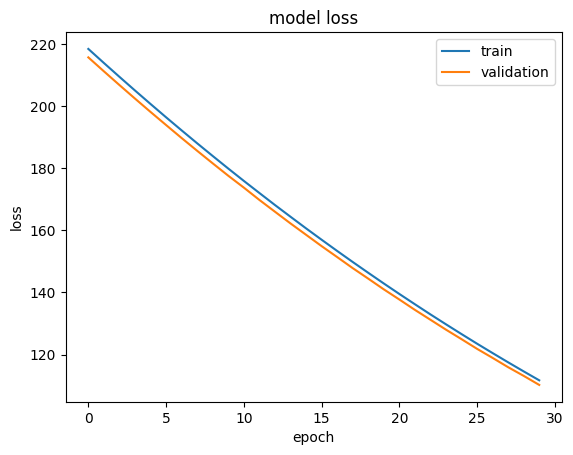

In [ ]:
plotloss(history,True)

In [ ]:
# Perform inference on the test data to get predicted labels
predicted_labels = model.predict(X_test_all)
predicted_labels = (predicted_labels > 0.5).astype(int)  # Convert probabilities to binary labels (0 or 1)

4345/4345 [==============================] - 208s 48ms/step


In [ ]:
# Calculate the confusion matrix
actual_labels = y_test_all
cm = confusion_matrix(actual_labels, predicted_labels)
acc = cm.diagonal()/cm.sum(axis=1)
print("accuracy for hail class:",acc[1])
print("accuracy for nohail class:",acc[0])

accuracy for hail class: 0.6506024096385542
accuracy for nohail class: 0.8596449533686219


In [ ]:
target_names = ['No Hail','Hail']

In [ ]:
print(classification_report(actual_labels, predicted_labels, target_names=target_names))

              precision    recall  f1-score   support

     No Hail       1.00      0.86      0.92    138855
        Hail       0.01      0.65      0.01       166

    accuracy                           0.86    139021
   macro avg       0.50      0.76      0.47    139021
weighted avg       1.00      0.86      0.92    139021



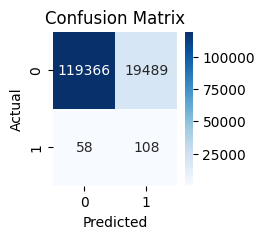

In [ ]:
plt.figure(figsize=(2, 2))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#Predict 2021 Hail Frequencies

In [9]:
modelPath = homedir + '/ERA5/model/hail_model.h5'

In [8]:
Eval1DataX = homedir + '/ERA5/tfds3/X_eval1.npy'
Eval1Datay = homedir + '/ERA5/tfds3/y_eval1.npy'

In [10]:
model_1 = tf.keras.models.load_model(modelPath)
model_1.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_34 (LSTM)              (None, 24, 276)           407376    
                                                                 
 dropout_33 (Dropout)        (None, 24, 276)           0         
                                                                 
 lstm_35 (LSTM)              (None, 24, 276)           610512    
                                                                 
 dropout_34 (Dropout)        (None, 24, 276)           0         
                                                                 
 lstm_36 (LSTM)              (None, 276)               610512    
                                                                 
 dropout_35 (Dropout)        (None, 276)               0         
                                                                 
 dense_20 (Dense)            (None, 276)             

2213/2213 [==============================] - 105s 47ms/step
              precision    recall  f1-score   support

           0       1.00      0.93      0.96     70765
           1       0.00      0.44      0.01        45

    accuracy                           0.93     70810
   macro avg       0.50      0.69      0.49     70810
weighted avg       1.00      0.93      0.96     70810



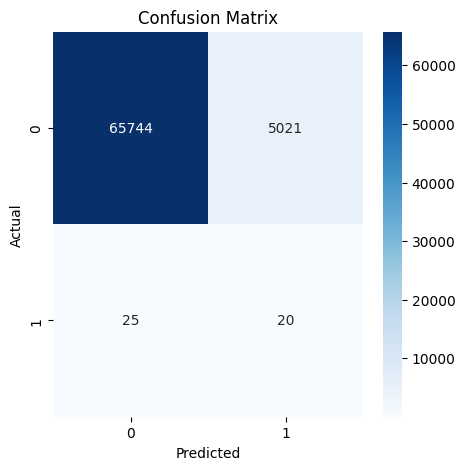

In [10]:
#Predict 2021 + Evaluate
actual_labels_2021 = np.load(Eval1Datay)
Eval1X = np.load(Eval1DataX)

pred_2021 = model_1.predict(Eval1X)
pred_labels_2021 = (pred_2021 > 0.5).astype(int)  # Convert probabilities to binary labels (0 or 1)

# Calculate the confusion matrix
print(classification_report(actual_labels_2021.reshape(-1,1), pred_labels_2021.reshape(-1,1)))
confusion = confusion_matrix(actual_labels_2021.reshape(-1,1), pred_labels_2021.reshape(-1,1))

# Plot the confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(confusion, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#Predict 2022 Hail Frequencies

In [7]:
Eval2DataX = homedir + '/ERA5/distributions/X_eval2.npy'
Eval2Datay = homedir + '/ERA5/distributions/y_eval2.npy'

2213/2213 [==============================] - 110s 50ms/step
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     70758
           1       0.00      0.10      0.01        52

    accuracy                           0.98     70810
   macro avg       0.50      0.54      0.50     70810
weighted avg       1.00      0.98      0.99     70810



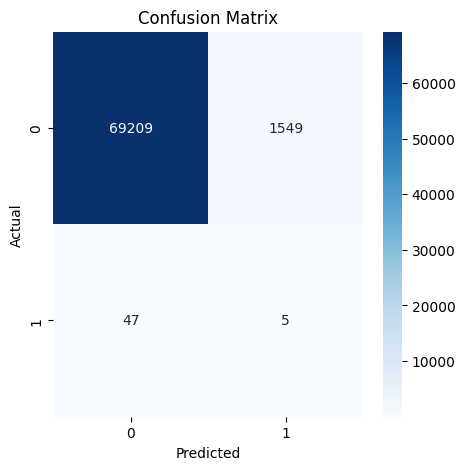

In [11]:
#Predict 2021 + Evaluate
actual_labels_2022 = np.load(Eval2Datay)
Eval2X = np.load(Eval2DataX)

pred_2022 = model_1.predict(Eval2X)
pred_labels_2022 = (pred_2022 > 0.5).astype(int)  # Convert probabilities to binary labels (0 or 1)

# Calculate the confusion matrix
print(classification_report(actual_labels_2022.reshape(-1,1), pred_labels_2022.reshape(-1,1)))
confusion = confusion_matrix(actual_labels_2022.reshape(-1,1), pred_labels_2022.reshape(-1,1))

# Plot the confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(confusion, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#Sum the 2022 probability distribution to compare with FEMA

In [12]:
DistDatak = homedir + '/ERA5/distributions/k_eval2.npy'
DistDataX = homedir + '/ERA5/distributions/X_eval2.npy'
DistDatay = homedir + '/ERA5/distributions/y_eval2.npy'

In [13]:
DistX = np.load(DistDataX)
Distk = np.load(DistDatak)
Disty = np.load(DistDatay)

In [14]:
#Run the model and collect the probability distributions for each cell
pred_dist = model_1.predict(DistX)

2213/2213 [==============================] - 131s 59ms/step


In [15]:
dist_out = []
for p in range(len(pred_dist)):
  dist_out.append([Distk[p],Disty[p],float(pred_dist[p])])

In [16]:
dist_outPD = pd.DataFrame(dist_out,columns=['key','label','predprob'])
dist_outPD.head()

,key,label,predprob
0,20220306340,1,6.820436e-27
1,20220307120,1,1.756878e-01
2,20220307142,1,9.748394e-04
3,20220323305,1,2.541092e-08
4,20220323339,1,6.826620e-04


In [17]:
dist_outPD.to_csv(homedir + '/ERA5/distributions/predprob.csv')